# Introdução do problema

Um dos grandes problemas enfrentados pelas instituições financeiras é a previsão de clientes inadimplentes. Um aumento de limite ou uma liberação de crédito a um cliente inadimplente pode gerar prejuízo a instituição financeira. Portanto, criar um sistema que de antemão consiga prever se um usuário será considerado inadimplente é de grande relevância.

Assumindo a premissa de que a instituição financeira está procurando identificar os inadimplentes para conceder ou aumentar limites de clientes, o banco deseja construir um modelo que maximiza os verdadeiros positivos - VP. Ou seja, criar um sistema que identifica realmente os maus pagadores, quando na realidade eles realmente são maus pagadores. Entretanto, dizer que um cliente é bom pagador, quando na verdade ele é mau pagador, é um problema maior do ponto de vista financeiro. Portanto, queremos minimizar os falsos negativos - FN (dizer que ele é bom pagador, quando na verdade não é).

Vamos realizar o carregamento dos dados coletados, e realizar algumas análises e tratamentos iniciais.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# configurando o tamanho das figuras
# plt.rcParams['figure.dpi'] = 100

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/case neon/UCI_Credit_Card.csv'

data = pd.read_csv(path)

df = data.copy()

In [ ]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
# renomeando as colunas e removendo a coluna ID que não será utilizada
df.drop('ID', axis=1, inplace=True)

In [ ]:
df.rename({
    'default.payment.next.month': 'default', 'LIMIT_BAL': 'credit_value', 'PAY_0': 'stat_pag_set',
    'PAY_2': 'stat_pag_ago', 'PAY_3': 'stat_pag_jul', 'PAY_4': 'stat_pag_jun', 'PAY_5': 'stat_pag_mai',
    'PAY_6': 'stat_pag_abr', 'BILL_AMT1': 'extract_set', 'BILL_AMT2': 'extract_ago', 'BILL_AMT3': 'extract_jul',
    'BILL_AMT4': 'extract_jun', 'BILL_AMT5': 'extract_mai', 'BILL_AMT6': 'extract_abr', 'PAY_AMT1': 'amount_pay_set',
    'PAY_AMT2': 'amount_pay_ago', 'PAY_AMT3': 'amount_pay_jul', 'PAY_AMT4': 'amount_pay_jun', 'PAY_AMT5': 'amount_pay_mai',
    'PAY_AMT6': 'amount_pay_abr', 'SEX': 'sex', 'EDUCATION': 'education', 'MARRIAGE': 'marriage', 'AGE': 'age'}, 
    axis=1, inplace=True)

In [ ]:
df.head()

,credit_value,sex,education,marriage,age,stat_pag_set,stat_pag_ago,stat_pag_jul,stat_pag_jun,stat_pag_mai,...,extract_jun,extract_mai,extract_abr,amount_pay_set,amount_pay_ago,amount_pay_jul,amount_pay_jun,amount_pay_mai,amount_pay_abr,default
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [ ]:
# verificando a existência de dados nulos e o formato dos dados em cada coluna
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   credit_value    30000 non-null  float64
 1   sex             30000 non-null  int64  
 2   education       30000 non-null  int64  
 3   marriage        30000 non-null  int64  
 4   age             30000 non-null  int64  
 5   stat_pag_set    30000 non-null  int64  
 6   stat_pag_ago    30000 non-null  int64  
 7   stat_pag_jul    30000 non-null  int64  
 8   stat_pag_jun    30000 non-null  int64  
 9   stat_pag_mai    30000 non-null  int64  
 10  stat_pag_abr    30000 non-null  int64  
 11  extract_set     30000 non-null  float64
 12  extract_ago     30000 non-null  float64
 13  extract_jul     30000 non-null  float64
 14  extract_jun     30000 non-null  float64
 15  extract_mai     30000 non-null  float64
 16  extract_abr     30000 non-null  float64
 17  amount_pay_set  30000 non-null 

É possível verificar que não há dados ausentes e o formato das variáveis está adequado ao prosseguimento do trabalho.

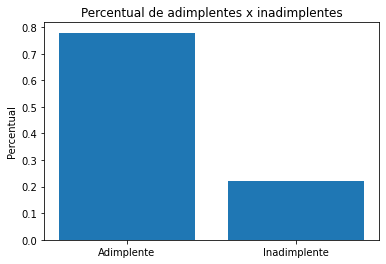

In [ ]:
# percentual de adimplentes e inadimplentes
counts_default = df['default'].value_counts(1)

plt.bar(counts_default.index, counts_default.values)
plt.xticks([0,1], ['Adimplente', 'Inadimplente'])
plt.title('Percentual de adimplentes x inadimplentes')
plt.ylabel('Percentual');

Como era esperado, a quantidade de inadimplentes (maus pagadores) é menor quando comparada aos adimplentes (bons pagadores).

Para esse tipo de problema é interessante verificarmos como está a distribuição desses clientes em relação as outras variáveis, pois caso seja difícil de encontrarmos um padrão de separação entre eles, será necessário realizar uma tarefa de balançeamento de classes, para que o algorítmo possa identificar melhor o que é um adimplente e um inadimplente.

Vamos analisar os efeitos da idade na variável target.

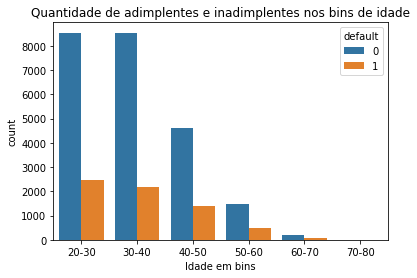

In [ ]:
df['age_bins'] = pd.cut(df['age'], [20,30,40,50,60,70,80], labels=[0,1,2,3,4,5])

sns.countplot(data=df, x='age_bins', hue='default')
plt.xticks([0,1,2,3,4,5], ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80'])
plt.title('Quantidade de adimplentes e inadimplentes nos bins de idade')
plt.xlabel('Idade em bins');

Através do gráfico acima podemos verificar que com o passar da idade, representada pelos bins, a quantidade de inadimplentes tende a diminuir. Vamos analisar esse resultado em percentuais.

In [ ]:
percentage_default_per_bin = round(
    df[['age_bins', 'default']].groupby('age_bins')['default'].sum() / df['age_bins'].value_counts(), 3)
percentage_default_per_bin

age_bins
0    0.224
1    0.204
2    0.233
3    0.252
4    0.265
5    0.333
dtype: float64

Este resultado nos mostra que o gráfico acima pode ser enganoso. Apesar da quantidade de clientes inadimplentes estar diminuindo com o aumento da idade, é necessario encontrar quantos inadimplentes existem dentro de cada bin, para termos uma noção deste percentual.

Com o passar do tempo, vemos um ligeiro aumento nos inadimplentes em cada bin, exceto da passagem do bin 0 (20-30 anos) para o bin 1 (30-40) anos.

Vamos analisar a variável marriage.

In [ ]:
df['marriage'].value_counts()

2    15964
1    13659
3      323
0       54
Name: marriage, dtype: int64

Temos 3 status para a variável marriage:

1: Casado;

2: Solteiro;

3: Outro.

Existem alguns não denominados pertencentes a classe 0, que representam um pequeno número comparado as outras classes. 

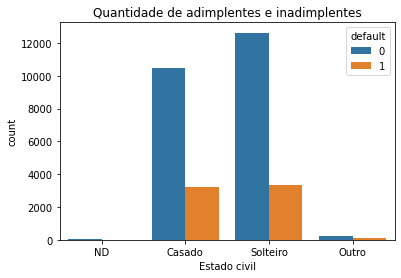

In [ ]:
sns.countplot(data=df, x='marriage', hue='default')
plt.title('Quantidade de adimplentes e inadimplentes')
plt.xticks([0, 1, 2, 3], ['ND', 'Casado', 'Solteiro', 'Outro'])
plt.xlabel('Estado civil');

In [ ]:
percentage_marriage_default = round(df.groupby('marriage')['default'].sum() / df['marriage'].value_counts(), 3)
percentage_marriage_default

0    0.093
1    0.235
2    0.209
3    0.260
dtype: float64

Aparentemente a quantidade de inadimplentes entre solteiros e casados é a mesma, mas, se levarmos em consideração o percentual de cada classe, vemos que comparando casados e solteiros, existe (percentualmente) mais inadimplentes entre os casados.

A classe denominada Outro não deveria ser negligenciada, pois apesar da sua quantidade ser pequena comparada as outras, seu percentual de inadimplentes é praticamente o mesmo dos casados.

Vamos analisar a variável Education.

In [ ]:
df['education'].value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: education, dtype: int64

Vamos realizar um simples tratamento nessa variável.

1: Pós graduação - PG;

2: Graduação - G;

3: Ensino médio - EM;

4: Outros - O.

As outras classes que também existem serão analisadas posteriormente com foco na modelagem. Talvez seja uma opção excluir as linhas que contém níveis de escolaridade que não são bem definidos.

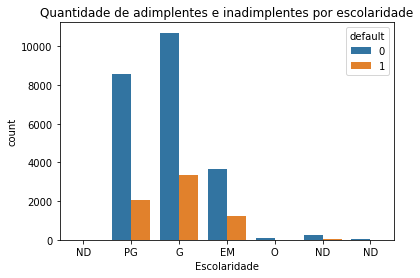

In [ ]:
sns.countplot(data=df, x='education', hue='default')
plt.title('Quantidade de adimplentes e inadimplentes por escolaridade')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['ND', 'PG', 'G', 'EM', 'O', 'ND', 'ND'])
plt.xlabel('Escolaridade');

In [ ]:
percentage_education_default = round(df.groupby('education')['default'].sum() / df['education'].value_counts(), 3)
percentage_education_default

0    0.000
1    0.192
2    0.237
3    0.252
4    0.057
5    0.064
6    0.157
dtype: float64

Dentro da classe graduados existe uma maior quantidade de inadimplentes, o que percentualmente não é maior do que a classe ensino médio.

Vamos analisar a variável sexo.

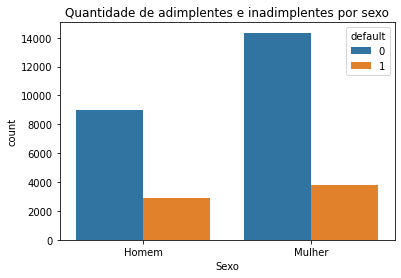

In [ ]:
sns.countplot(data=df, x='sex', hue='default')
plt.title('Quantidade de adimplentes e inadimplentes por sexo')
plt.xticks([0, 1], ['Homem', 'Mulher'])
plt.xlabel('Sexo');

In [ ]:
percentage_sex_default = round(df.groupby('sex')['default'].sum() / df['sex'].value_counts(), 3)
percentage_sex_default

1    0.242
2    0.208
dtype: float64

Apararentemente as mulheres são mais inadimplentes do que os homens, porém, percentualmente, vemos que isso não é verdade, pois existem mais mulheres do que homens em nossa base de dados. A quantidade de mulheres adimplentes é maior do que a quantidade de homens. Por isso a análise percentual entre as classes.

Portanto, vemos que pessoas entre 40 - 60 anos, casadas, do sexo masculino tendem a ser mais inadimplentes quando comparadas as outras classes.

Vamos analisar a correlação de Pearson destas variáveis com a variável alvo.

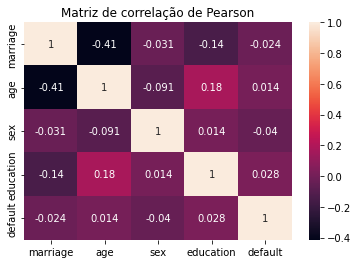

In [ ]:
first_vars = ['marriage', 'age', 'sex', 'education', 'default']

corr = df[first_vars].corr()

sns.heatmap(data=corr, annot=True)
plt.title('Matriz de correlação de Pearson');

As variáveis discutidas até então possuem uma correlação de Pearson relativamente pequena com a variável alvo, o que indica que sozinhas elas não conseguem explicar muito bem os efeitos da inadimplência. Entretanto, ao serem combinadas com outras, seus efeitos podem ser significativos.

A variável age e marriage possuem uma correlação mais forte entre si, o que também é de se esperar. O coeficiente de correlação é negativo, o que indica uma dependência inversa entre as variáveis. Portanto, quanto menor é o valor de age (mais jovem é uma pessoa) maior é o valor de marriage (1 corresponde a uma pessoa casada e 0 a uma pessoa solteira). Portanto, quanto mais velha é uma pessoa, maior a change dela estar enquadrada entre o grupo dos casados.

Vamos avaliar as variáveis que restaram.

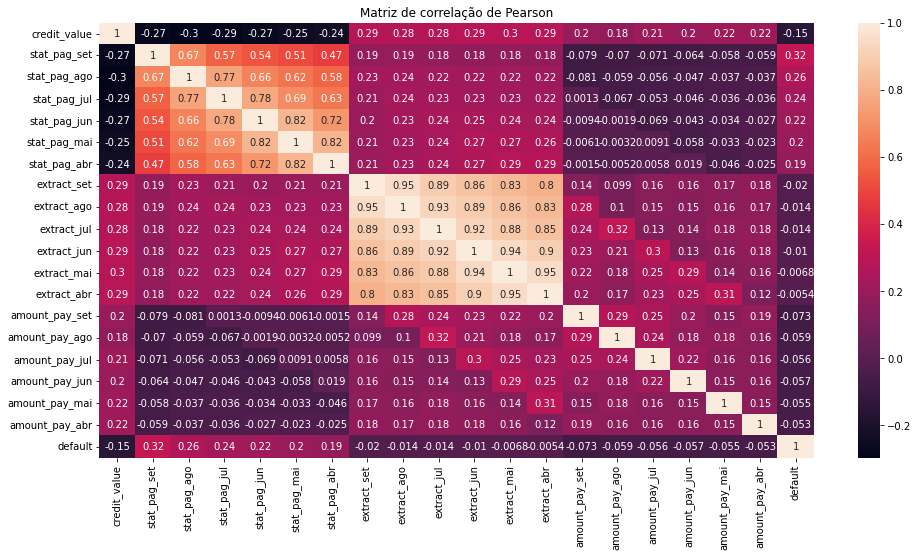

In [ ]:
second_vars = ['marriage', 'age', 'sex', 'education']

corr = df.drop(second_vars, axis=1).corr()

plt.figure(figsize=(16,8))
sns.heatmap(data=corr, annot=True)
plt.title('Matriz de correlação de Pearson');

Aqui já conseguimos ver que as variáveis do grupo stat_pag possuem uma boa correlação com a variável alvo. Todas apresentam aproximadamente uma correlação maior do que 20% com o default. Stat_pag é uma variável que descreve o status do pagamento no referido mês.

Por exemplo: -1 se o cliente efetua o pagamento em dia; 1 caso o cliente atrase em 1 mês; 2 para um atraso de 2 meses, e assim sucessivamente.

Portanto, como as correlações desta variável com a variável alvo é positiva, quanto maior o valor dela, maior será o valor da variável alvo, ou seja, o cliente irá defaultar, não efetuar o pagamento. **Ou seja, quanto maior o atraso do pagamento nos meses anteriores, maior a change do cliente não efetuar o pagamento no próximo mês**. Sendo assim, é viável acompanhar o cliente mês a mês, para analisar com cautela seus pagamentos anteriores e já antecipar possíveis inadimplências.

Um dos pontos interessantes desta variável é a presença do efeito *bola de neve*. O status do pagamento de setembro, é influenciado fortemente pelo pagamento em agosto, que é influenciado pelo pagamento de julho, e assim sucessivamente. No gráfico é notável o aumento do coeficiente de correlação entre essas variáveis com o passar dos referidos meses.

Outro ponto interessante é a variável credit_value, que representa o valor do crédito concedido ao cliente. Pensando em termos de rendimentos, geralmente é necessário que um cliente tenha uma renda maior para possuir um limite mais alto, e o coeficiente de correlação mostra que essa variável possui um efeito negativo em nossa variável alvo. Portanto, quanto menor o valor do crédito concedido ao cliente, maior o valor da variável alvo. Isso não quer dizer que a instituição deva fornecer altos valores de crédito ao cliente, mas que um limite de crédito baixo, pode ser devido a baixos valores de renda, e valores pequenos de renda, podem levar o cliente a consumir demasiadamente e desenfreadamente o limite do cartão de crédito, levando mais facilmente o cliente a inadimplência.

# Modelagem

Vamos testar 3 algoritmos em uma primeira análise: regressão logística, k vizinhos mais próximos e floresta aleatória. Ambos os três modelos serão treinados e avaliados utilizando como métrica escolhida a precisão, que está associada a identificação correta dos verdadeiros positivos (inadimplentes).

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics

In [ ]:
# downsampling nos dados
default_0 = df[df['default']==0]
default_1 = df[df['default']==1]

new_default_0 = default_0.sample(len(default_1), random_state=42)

df_filter = pd.concat([new_default_0, default_1])

In [ ]:
x = df_filter.drop(['default', 'age_bins'], axis=1)
y = df_filter['default']

# dividindo o conjunto de dados em 3: treino, teste e validação (que será utilizado apenas no fim da modelagem)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, stratify=y_test, test_size=0.5, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

models = {'logreg': LogisticRegression(), 'knn': KNeighborsClassifier(), 
          'tree': DecisionTreeClassifier(), 'forest': RandomForestClassifier(),
          'bayes': GaussianNB()}

In [ ]:
def training_models(models, x_train, y_train):
  fitted_models = {}
  for algorithm in models.keys():
    model = models[algorithm]
    model.fit(x_train, y_train)
    fitted_models.update({algorithm: model})
  return fitted_models

def get_metrics(fitted_models, x_train, x_test, y_train, y_test):
  results = {}
  for algorithm in fitted_models.keys():
    model = models[algorithm]
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    precision_train = round(metrics.precision_score(y_train, pred_train), 2)
    recall_train = round(metrics.recall_score(y_train, pred_train), 2)
    precision_test = round(metrics.precision_score(y_test, pred_test), 2)
    recall_test = round(metrics.recall_score(y_test, pred_test), 2)

    results.update({algorithm: {'precision train': precision_train, 'precision test': precision_test,
                                'recall train': recall_train, 'recall test': recall_test}})
    results_df = pd.DataFrame(results).T
  return results_df

In [ ]:
fitted_models = training_models(models, x_train, y_train)

get_metrics(fitted_models, x_train, x_test, y_train, y_test)

,precision train,precision test,recall train,recall test
logreg,0.63,0.63,0.46,0.45
knn,0.72,0.59,0.73,0.58
tree,1.00,0.61,1.00,0.58
forest,1.00,0.72,1.00,0.62
bayes,0.52,0.52,0.93,0.91


O método utilizado aqui para avaliar os modelos é observar o resultado da precisão nos próprios dados de treino e nos dados de teste. Em geral, modelos que apresentam resultados próximos de uma métrica em ambos os conjuntos de dados apresentam bons ajustes. Entretanto, caso a performance nos dados de treinamento estejam muito maiores do que nos dados de teste, temos um indício de sobreajuste.

Pela tabela acima, podemos perceber que o modelo de regressão e bayes se ajustaram bem aos dados, mas que knn, árvore e floresta, aparentemente apresentaram um sobreajuste. Isso pode ser contornado com a utilização de técnicas de regularização dos algorítmos, como limitar o crescimento das árvores e otimizar o número de vizinhos no cálculo da semelhança no modelo de knn.

Façamos mais alguns testes antes de focar específicamente em um algorítmo.

In [ ]:
filter_columns = ['stat_pag_set', 'stat_pag_ago', 'stat_pag_jul', 'stat_pag_jun', 'stat_pag_mai', 'stat_pag_abr']
x_train2 = x_train[filter_columns]
x_test2 = x_test[filter_columns]

In [ ]:
fitted_models2 = training_models(models, x_train2, y_train)

get_metrics(fitted_models2, x_train2, x_test2, y_train, y_test)

,precision train,precision test,recall train,recall test
logreg,0.76,0.75,0.56,0.55
knn,0.69,0.65,0.64,0.62
tree,0.82,0.75,0.58,0.54
forest,0.81,0.74,0.60,0.56
bayes,0.81,0.78,0.51,0.49


Houve um aumento na precisão dos modelos. Isso se deve apenas a escolha destas variáveis para utilização no modelo. As variáveis escolhidas analisam o comportamento dos clientes ao longo do tempo desde abril até setembro, ou seja, durante 6 meses. Se observarmos a correlação destas variáveis com a variável target elas são as que apresentam o maior valor, por isso a escolha de se fazer o teste com elas e também aliado a discussão acima acerca do comportamento do cliente.

Podemos considerar que esse modelo é um tipo de modelo de behaviour, em que o comportamento do cliente é acompanhado durante um certo tempo (no mercado acompanha-se durante 6 meses ou 1 ano) e avalia-se se houve ou não um atraso (geralmente atraso de 60 dias em 6 meses ou 90 dias em 1 ano).

O ponto importante aqui é encontrar um modelo que apresente um equilíbrio entre precisão e recall. Vamos escolher o algorítmo de knn para aprimorá-lo com uma otimização dos parâmetros.

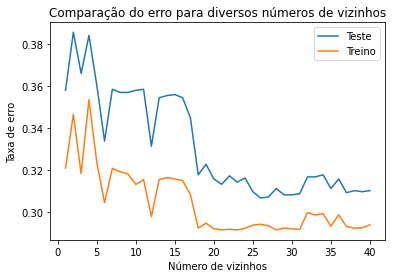

In [ ]:
num_neighbors = np.arange(1, 41)

error_rate = []
error_rate_train = []
for i in num_neighbors:
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(x_train2, y_train)
  pred_i = knn.predict(x_test2)
  pred_i_train = knn.predict(x_train2)
  error_rate.append(np.mean(pred_i != y_test))
  error_rate_train.append(np.mean(pred_i_train != y_train))

plt.plot(num_neighbors, error_rate, label='Teste')
plt.plot(num_neighbors, error_rate_train, label='Treino')
plt.legend()
plt.xlabel('Número de vizinhos')
plt.title('Comparação do erro para diversos números de vizinhos')
plt.ylabel('Taxa de erro');

Alterando-se o número de vizinhos no treinamento dos modelos é possível verificar uma queda na taxa de erro tanto nos dados de treino quanto nos dados de teste. Buscaremos otimizar esse comportamento escolhendo o número de vizinhos como sendo 25.

É importante destacar que a diferença no erro nos dados de treino e teste permanece praticamente inalterada com a mudança no número de vizinhos, isso se deve ao fato de que talvez seja necessário mais features. Porém, acreditamos que essa diferença de aproximadamente 2 - 3% está aceitável para o número de vizinhos igual a 25.

Façamos mais alguns testes antes de prosseguir.

In [ ]:
fitted_knn = []
for neighbors in num_neighbors:
  models = {'knn': KNeighborsClassifier(n_neighbors=neighbors)}
  fitted = training_models(models, x_train2, y_train)
  fitted_knn.append(fitted)

In [ ]:
precision_results = {}
recall_results = {}
for pos, model in enumerate(fitted_knn, 1):
  pred_train = model['knn'].predict(x_train2)
  pred_test = model['knn'].predict(x_test2)

  precision_train = round(metrics.precision_score(y_train, pred_train), 2)
  recall_train = round(metrics.recall_score(y_train, pred_train), 2)

  precision_test = round(metrics.precision_score(y_test, pred_test), 2)
  recall_test = round(metrics.recall_score(y_test, pred_test), 2)

  precision_results.update({pos: {'train': precision_train, 'test': precision_test}})
  recall_results.update({pos: {'train': recall_train, 'test': recall_test}})

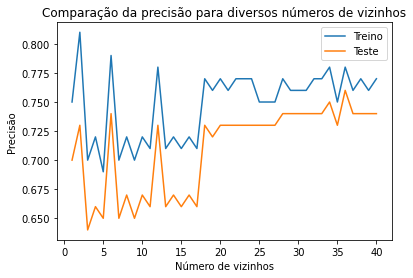

In [ ]:
plt.plot(num_neighbors, [precision_results[i]['train'] for i in num_neighbors], label='Treino')
plt.plot(num_neighbors, [precision_results[i]['test'] for i in num_neighbors], label='Teste')
plt.xlabel('Número de vizinhos')
plt.ylabel('Precisão')
plt.legend()
plt.title('Comparação da precisão para diversos números de vizinhos');

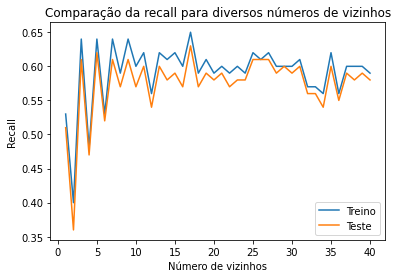

In [ ]:
plt.plot(num_neighbors, [recall_results[i]['train'] for i in num_neighbors], label='Treino')
plt.plot(num_neighbors, [recall_results[i]['test'] for i in num_neighbors], label='Teste')
plt.xlabel('Número de vizinhos')
plt.ylabel('Recall')
plt.legend()
plt.title('Comparação da recall para diversos números de vizinhos');

Ao realizar tais testes, é possível verificar que o número de vizinhos igual a 25 é um bom valor, pois apresenta um bom balanceamento entre precision e recall.

A precision está em torno de 75% nos dados de treino e 73% nos dados de teste.

O recall está em torno de 60% tanto nos dados de treino quanto nos dados de teste.

Vamos então finalmente treinar um algoritimo com essas características e testá-lo nos dados de validação que foram separados inicialmente.

# Modelo Final

Será treinado um modelo no qual será utilizado dados de validação nunca vistos pelo algorítimo. Esse teste fornecerá uma estimativa do desempenho real do modelo quando estiver em funcionamento (deploy).

É importante destacar que esse desempenho deve ser parecido com o que foi obtido na discussão acima, precisão em torno de 75% e recall em torno de 60%.

In [ ]:
x_val2 = x_val[filter_columns]

model_final = KNeighborsClassifier(n_neighbors=25)

model_final.fit(x_train2, y_train)

final_pred_test = model_final.predict(x_val2)

In [ ]:
final_precision = round(metrics.precision_score(y_val, final_pred_test), 2)
final_recall = round(metrics.recall_score(y_val, final_pred_test), 2)

print('Precision:', final_precision)
print('Recall:', final_recall)

Precision: 0.76
Recall: 0.61


In [ ]:
print(metrics.classification_report(y_val, final_pred_test))

              precision    recall  f1-score   support

           0       0.67      0.81      0.73       996
           1       0.76      0.61      0.68       995

    accuracy                           0.71      1991
   macro avg       0.72      0.71      0.71      1991
weighted avg       0.72      0.71      0.71      1991



Os resultados obtidos bateram com o que era esperado do modelo. Então, o mesmo pode ser utilizado com uma precisão de 76% e um recall de 61%.

# Discussão final dos resultados

Podemos discutir os resultados do modelo acima separando em duas classes: Adimplentes e inadimplentes.

**Adimplentes:**

Precisão de 67% e Recall de 81%.

**Inadimplentes:**

Precisão de 76% e Recall de 61%.

Vamos traduzir esses resultados para compreender melhor em como nosso modelo pode ser útil a instituição financeira.

Suponhamos que uma instituição tenha 1000 clientes. Destes, 200 são considerados inadimplentes, ou seja, vão descumprir o pagamento do cartão em um certo mês. O modelo acima será útil para identificar esses clientes antecipadamente para o banco. Para isso, basta o banco acompanhar tais clientes por 6 meses e avaliar os seus pagamentos (behaviour) ao longo deste tempo e então terá uma estimativa se eles irão ou não pagar no próximo mês.

**Inadimplentes:**

Um recall de 61% quer dizer que dos 200 existentes, o modelo consegue identificar antecipadamente cerca de 122 deles.

Uma precisão de 76% quer dizer que de todos os classificados como inadimplentes, ele acerta em 76% dos casos. Ou seja, existe uma margem de erro quando classificamos o cliente como inadimplente mas na verdade ele não é.

**Adimplentes:**

Um recall de 81%, quer dizer que dos 800 existentes, o modelo consegue identificar antecipadamente cerca de 648.

Uma precisão de 81% quer dizer que de todos os classificados como adimplentes, ele acerta em 81% dos casos. Ou seja, existe uma margem de erro quando classificamos o cliente como adimplente mas na verdade ele não é.

**Observação:** Portanto, podemos inserir esses resultados numéricos em exemplos clássicos de negócio, no qual podemos estipular um retorno financeiro quando não utilizamos modelo algum, e quando este modelo é utilizado.